In [3]:
# !pip install pvbm --upgrade

In [4]:
from PIL import Image,ImageFilter
import numpy as np 
import matplotlib.pyplot as plt 
from skimage.morphology import skeletonize,square,dilation 

from PVBM.GeometricalAnalysis import GeometricalVBMs
from PVBM.FractalAnalysis import MultifractalVBMs

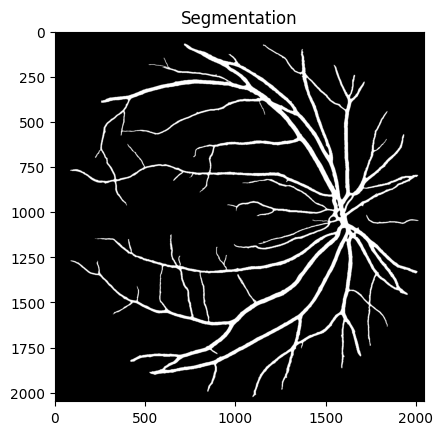

In [20]:
segmentation_path = "data/data_m_vessel/test/control/479_N.png"
segmentation = Image.open(segmentation_path)
plt.imshow(segmentation,cmap = "gray")
plt.title("Segmentation")
plt.show()

In [21]:
# Depending on the quality of the segmentation, you would need to regularize (smooth) it more or less 
#before computing the skeleton for instance by uncomment the following command
segmentation = segmentation.filter(ImageFilter.ModeFilter(size=3))

segmentation = np.array(segmentation)/255 #Convert the segmentation to a numpy array with value 0 and 1
segmentation = segmentation[:,:,0]

skeleton = skeletonize(segmentation) # Compute the skeleton of the segmentation


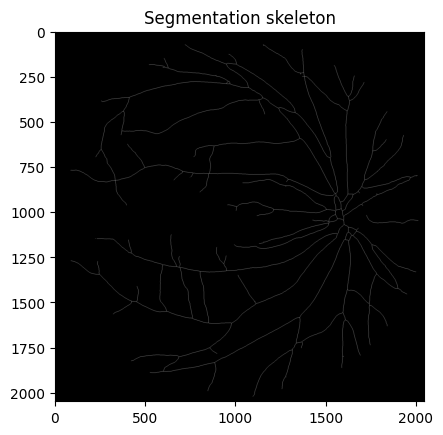

In [22]:
plt.imshow(skeleton,cmap = 'gray')
plt.title("Segmentation skeleton")
plt.show()

## Compute the area

In [23]:
geometricalVBMs = GeometricalVBMs()

In [24]:
a = geometricalVBMs.area(segmentation)
print("The area is {}".format(a))

The area is 368730.0


## Compute the endpoints and intersection points

In [25]:
n_end,n_inter,end,inter = geometricalVBMs.compute_particular_points(skeleton)
print("There is {} endpoints and {} intersection points".format(n_end,n_inter))

There is 76 endpoints and 352 intersection points


In [26]:
#Dilation of the endpoints and intersection points for vizualisation
end_dilated = dilation(end, square(15))
inter_dilated = dilation(inter, square(15))

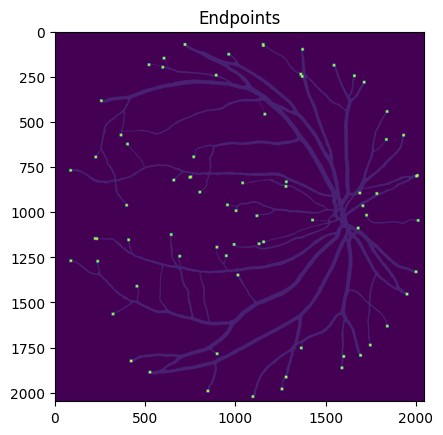

In [27]:
plt.imshow(segmentation/10+end_dilated)
plt.title('Endpoints')
plt.show()


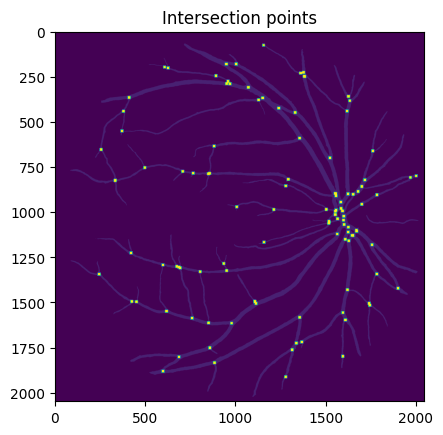

In [28]:
plt.imshow(segmentation/10+inter_dilated)
plt.title("Intersection points")
plt.show()


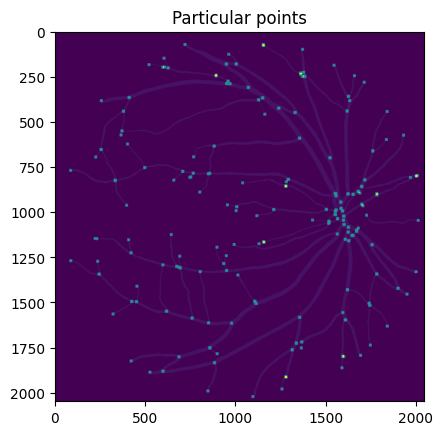

In [29]:
plt.imshow(segmentation/10+inter_dilated+end_dilated)
plt.title("Particular points")
plt.show()

## Compute the tortuosity and the length

In [30]:
median_tor, length,chord,arc,connection_dico = geometricalVBMs.compute_tortuosity_length(skeleton)

In [31]:
print("The median tortuosity is {}".format(median_tor))

The median tortuosity is 1.0775933558124562


In [32]:
print("Here is the list containing the arc length of every blood vessels (between two particular points) {}."
      .format(arc[:3]))

Here is the list containing the arc length of every blood vessels (between two particular points) [272.7350647362948, 277.7472580451148, 133.6274169979695].


In [33]:
print("Here is the list containing the chord length of every blood vessels (between two particular points) {}."
      .format(chord[:3]))

Here is the list containing the chord length of every blood vessels (between two particular points) [252.28555249954366, 255.60125195311545, 127.1416532848303].


In [34]:
print("We can recompute the median tortuosity:{} and we can compute the tortuosity index: {}."
      .format(np.median(np.array(arc)/np.array(chord)), np.sum(arc)/np.sum(chord)))

We can recompute the median tortuosity:1.0775933558124562 and we can compute the tortuosity index: 1.079668435248491.


In [35]:
print("The length is {}".format(length))

The length is 26470.061300751062


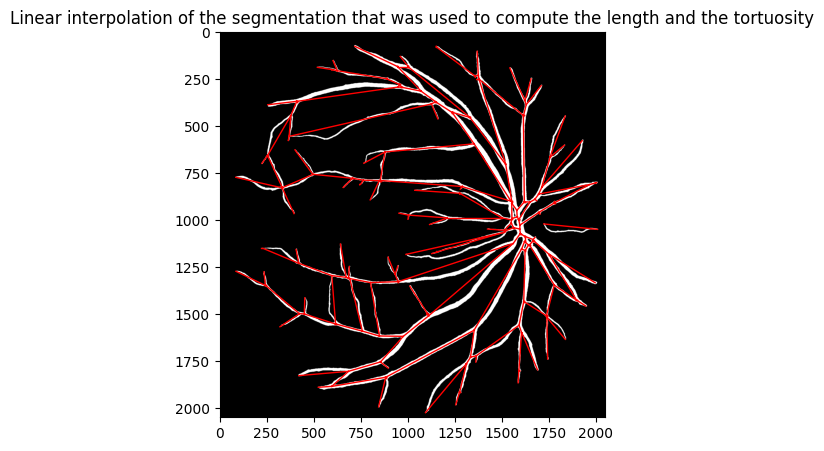

In [36]:
fig = plt.figure(figsize=(5,5))
for key,values in connection_dico.items():
    x1,y1 = key
    for value in values:
        x2,y2 = value[0][0],value[0][1]
        x_ = (x1,x2)
        y_ = (y1,y2)
        plt.plot(y_,x_, color="red", linewidth=1)
plt.imshow(segmentation,cmap = 'gray')
plt.title('Linear interpolation of the segmentation that was used to compute the length and the tortuosity')
plt.show()

## Compute the perimeter

In [37]:
p,border_matrix = geometricalVBMs.compute_perimeter(segmentation) #times depends in the resolution of the segmentation (smaller is faster)

In [38]:
print("The perimeter is {}".format(p))

The perimeter is 55052.60775815177


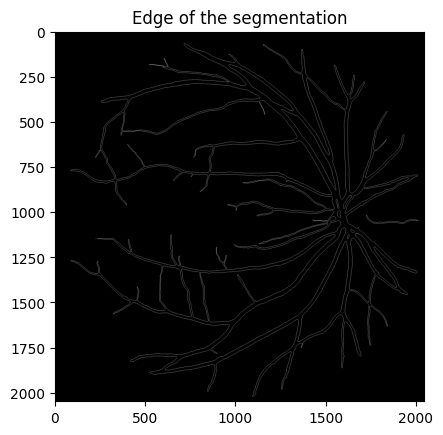

In [39]:
plt.imshow(border_matrix,cmap = "gray")
plt.title("Edge of the segmentation")
plt.show()

## Branching angles

In [40]:
mean_ba,std_ba,median_ba,angle_dico,centroid = geometricalVBMs.compute_branching_angles(skeleton)

In [41]:
mean_ba,std_ba,median_ba
print("The mean, std and median branching angles are mean: {}, std: {}, median: {}".format(mean_ba,std_ba,median_ba))

The mean, std and median branching angles are mean: 97.07328119068883, std: 44.40922575914279, median: 94.52766728287868


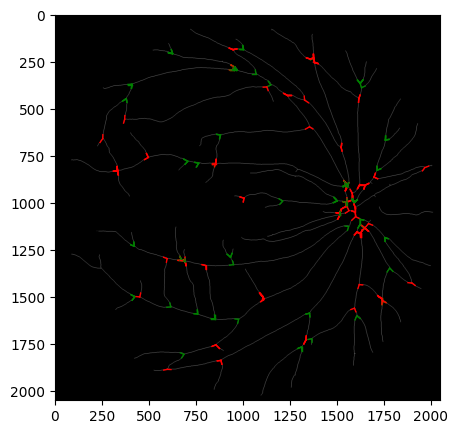

In [42]:
fig = plt.figure(figsize=(5,5))
for points,angle in angle_dico.items():
    b,a,c = points
    if True:
        if angle > 90 :
            x_ = [b[0],a[0]]
            y_ = [b[1],a[1]]
            plt.plot(y_,x_, color="red", linewidth=1)
            x_ = [b[0],c[0]]
            y_ = [b[1],c[1]]
            plt.plot(y_,x_, color="red", linewidth=1)
        if angle < 90 :
            x_ = [b[0],a[0]]
            y_ = [b[1],a[1]]
            plt.plot(y_,x_, color="green", linewidth=1)
            x_ = [b[0],c[0]]
            y_ = [b[1],c[1]]
            plt.plot(y_,x_, color="green", linewidth=1)
plt.imshow(skeleton,cmap = 'gray')
plt.show()

The centroid can also be ploted (independent for each subgraph)

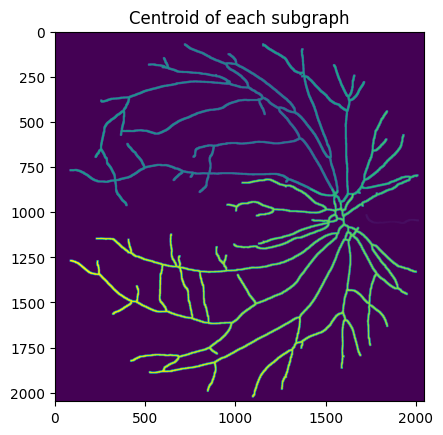

In [43]:
plt.imshow(dilation(centroid,square(10)))
plt.title("Centroid of each subgraph")
plt.show()

Lets extract each subgraph and their centroid

In [44]:
graphs = 1*(centroid != -1)

In [45]:
from queue import PriorityQueue
def iterative(A, B, i, j, n):
  pq = PriorityQueue()
  pq.put((0,A,B,i,j,n))
  priotities = [0,1,2,3,4,5,6,7]
  while not pq.empty():
    _,A, B, i, j, n = pq.get()
    directions = [(i-1,j),(i+1,j),(i,j-1),(i,j+1),(i-1,j-1),(i-1,j+1),(i+1,j-1),(i+1,j+1)]
    for direction,priority in zip(directions,priotities):
      x,y = direction
      if x >= 0 and x < A.shape[0] and y >= 0 and y < A.shape[1] and A[direction] == 1:
            B[direction] = n
            A[direction] = 0
            pq.put((priority,A,B,direction[0],direction[1],n))


In [46]:
from tqdm.notebook import tqdm
def extract_subgraphs(graphs):
    B = np.zeros_like(graphs)
    n = 1
    for i in tqdm(range(graphs.shape[0])):
        for j in range(graphs.shape[1]):
            if B[i,j] == 0 and graphs[i,j] == 1:
                iterative(graphs,B,i,j,n)
                n+=1
    return B
    
    

In [47]:
B = extract_subgraphs(graphs.copy())

  0%|          | 0/2048 [00:00<?, ?it/s]

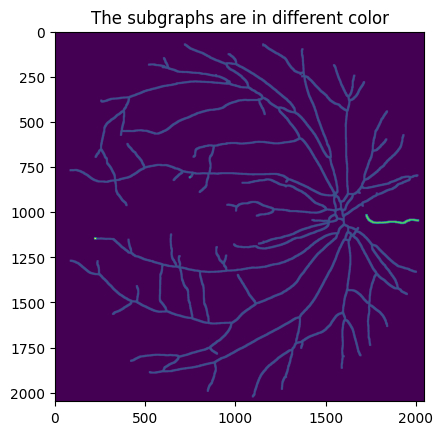

In [48]:
plt.imshow(dilation(B*100,square(10)))
plt.title("The subgraphs are in different color")
plt.show()

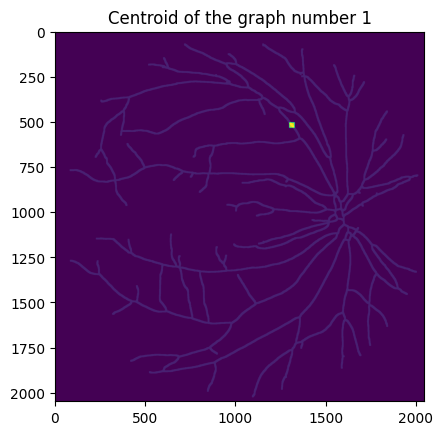

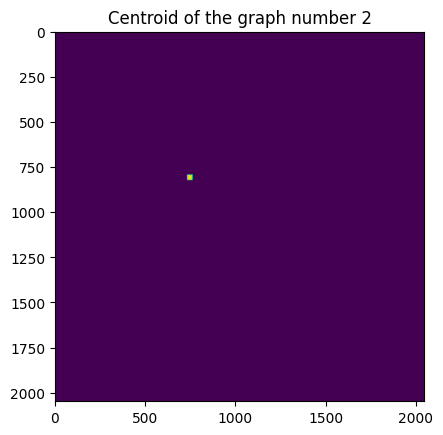

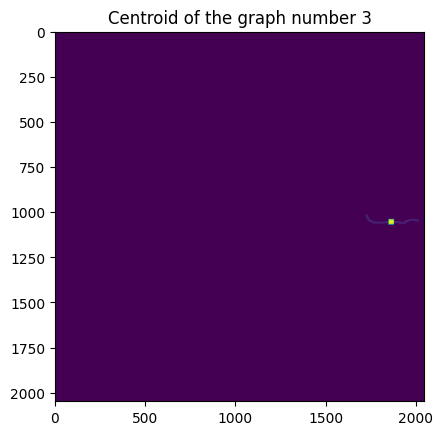

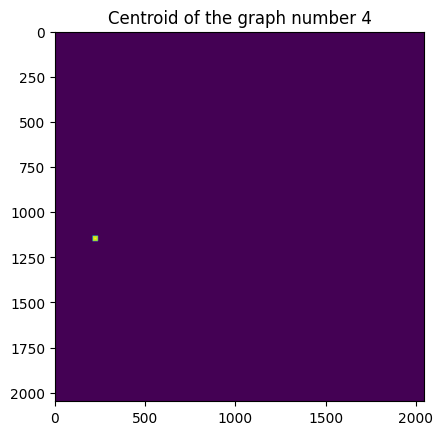

In [49]:
for i in range(1,B.max()+1):
    mask = B == i
    sub_skeleton = skeleton * mask
    sub_centroid = centroid * mask
    sub_centroid_tmp = sub_centroid.copy()
    sub_centroid_tmp[sub_centroid_tmp == 0 ] = np.inf
    detected_centroid = sub_centroid_tmp == sub_centroid_tmp.min()
    plt.imshow(dilation(sub_skeleton,square(10)) + 10*dilation(detected_centroid,square(30)))
    plt.title("Centroid of the graph number {}".format(i))
    plt.show()
    

## Fractal Analysis

In [50]:
fractalVBMs = MultifractalVBMs(n_rotations = 25,optimize = True, min_proba = 0.0001, maxproba = 0.9999)

In [51]:
D0,D1,D2,SL = fractalVBMs.compute_multifractals(segmentation)

In [52]:
print("The fractal biomarkers are D0: {}, D1: {}, D2: {}, SL: {}".format(D0,D1,D2,SL))

The fractal biomarkers are D0: 1.4893880023923842, D1: 1.4796802299777612, D2: 1.4712304369069156, SL: 0.7822807101910789
